In [1971]:
%matplotlib ipympl
import time
import pandas
import traceback
from onix.data_tools import get_experiment_data, open_analysis_folder, get_analysis_file_path
from functools import partial
from onix.analysis.fitter import Fitter
from onix.analysis.helper import group_and_average_data
from onix.helpers import present_float
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import voigt_profile
import allantools
from tqdm import tqdm
from uncertainties import ufloat, unumpy
from scipy.stats import pearsonr
from allantools import adev

In [2008]:
def phase_fit(phi, A, B, C, phi_0):
    return A * np.cos(phi - phi_0) +  B * phi + C

def get_phase_fitter(phases, heights, height_errs):
    fitter = Fitter(phase_fit)
    fitter.set_data(phases, heights, height_errs)
    fitter.set_bounds("A", 0, np.inf)

    # setting this bound makes weird fits for certain phi_0's because they want to fit to a value outside the bound
    # fitter.set_bounds("phi_0", 0, 2*np.pi)
    fitter.fit()
    return fitter

In [436]:
def data_identification_to_list(data_identification):
    if isinstance(data_identification, tuple):
        return range(data_identification[0], data_identification[1] + 1)
    elif isinstance(data_identification, int):
        return [data_identification]
    else:
        # it should be a list
        return data_identification

In [285]:
def get_normalized_transmission(data_number):
    data, header = get_experiment_data(data_number)
    detunings_MHz = header["detunings"].to("MHz").magnitude
    transmissions_avg, transmissions_err = group_and_average_data(data["transmissions_avg"], header["params"]["detect"]["cycles"], return_err=True)
    monitors_avg, monitors_err = group_and_average_data(data["monitors_avg"], header["params"]["detect"]["cycles"], return_err=True)
    normalized_avg = {}
    for kk in transmissions_avg:
        if transmissions_avg[kk].ndim >= 1:
            normalized_avg[kk] = unumpy.uarray(
                transmissions_avg[kk] / monitors_avg[kk],
                np.sqrt(
                    (transmissions_err[kk] / monitors_avg[kk]) ** 2
                    + (transmissions_avg[kk] * monitors_err[kk] / monitors_avg[kk]) ** 2
                )
            )
        else:
            normalized_avg[kk] = ufloat(
                transmissions_avg[kk] / monitors_avg[kk],
                np.sqrt(
                    (transmissions_err[kk] / monitors_avg[kk]) ** 2
                    + (transmissions_avg[kk] * monitors_err[kk] / monitors_avg[kk]) ** 2
                )
            )
    return detunings_MHz, normalized_avg, header

In [504]:
def get_experiment_result(data_number):
    detunings, data, header = get_normalized_transmission(data_number)
    total_pop_1 = 1#data["1"] - data["2"]
    pop_other_state_1 = -data["3"]#data["1"] - data["3"]
    total_pop_2 = 1#data["4"] - data["5"]
    pop_other_state_2 = -data["6"]#data["4"] - data["6"]
    # print(total_pop_1, total_pop_2)
    return (header, pop_other_state_1 + pop_other_state_2, total_pop_1 + total_pop_2)

In [505]:
def get_results(data_identification):
    data_list = data_identification_to_list(data_identification)
    headers = []
    results = []
    for data_number in data_list:
        header, pop_other_state, total_pop = get_experiment_result(data_number)
        headers.append(header)
        results.append(pop_other_state / total_pop)
    return headers, np.array(results)

In [659]:
def averaging_ys(xs, ys):
    xs_unique = np.unique(xs)
    ys_to_avg = [[] for _ in range(len(xs_unique))]
    for x, y in zip(xs, ys):
        ys_to_avg[np.argwhere(xs_unique == x)[0][0]].append(y)
    ys_avg = []
    ys_std = []
    for y_list in ys_to_avg:
        ys_avg.append(np.average(y_list))
        ys_std.append(np.std(y_list))
    ys_avg = np.array(ys_avg)
    ys_std = np.array(ys_std)
    
    return xs_unique, ys_avg, ys_std

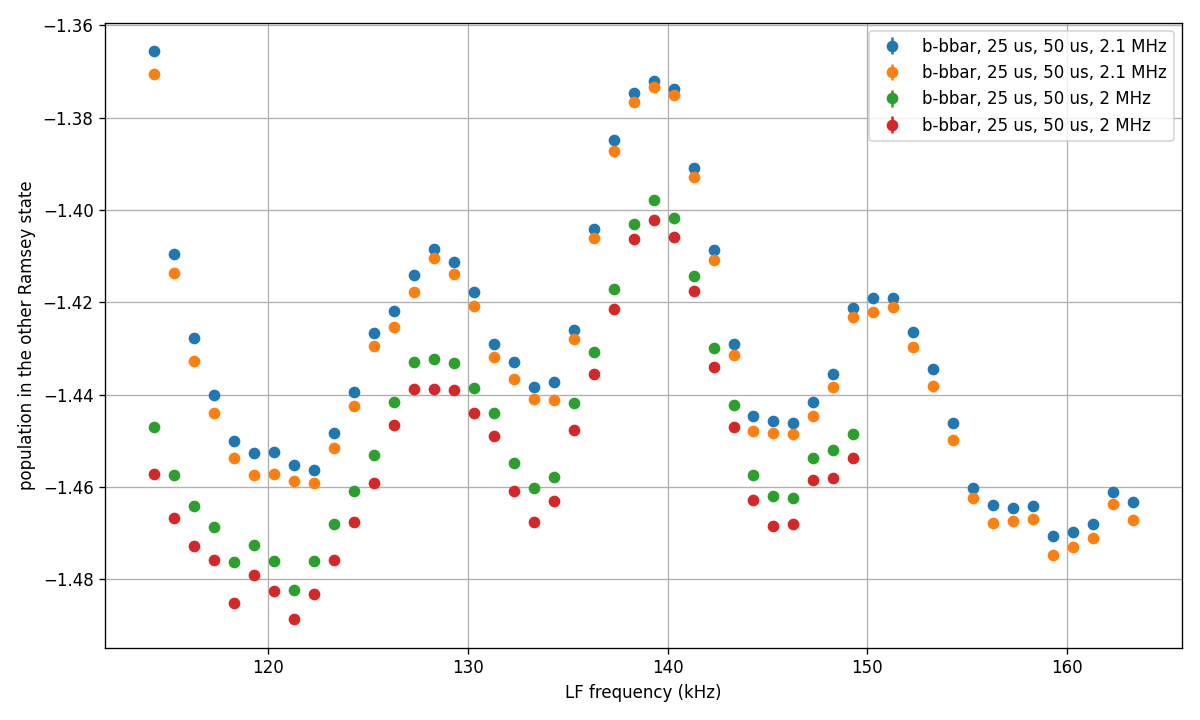

In [593]:
data = {
    # "a-abar, 90 us, 90 us": (978080, 978109),
    # "b-bbar, 25 us, 50 us": (985461, 985510),
    # "a-b, 5000, 100 us": (1031448, 1031647),
    "b-bbar, 25 us, 50 us, 2.1 MHz": (1036477, 1036526),
    "b-bbar, 25 us, 50 us, 2 MHz": (1036570, 1036605),
}

fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    headers, results = get_results(data_range)
    xs = [(header["params"]["lf"]["detunings"][0] + header["params"]["lf"]["center_frequencies"][0]).to("kHz").magnitude for header in headers]
    if results.ndim == 1:
        ys = unumpy.nominal_values(results)
        errs = unumpy.std_devs(results)
        ax.errorbar(xs, ys, errs, label=label, marker='o', linestyle='')
    else:
        for kk in range(1):
            ys = unumpy.nominal_values(results[:, kk])
            errs = unumpy.std_devs(results[:, kk])
            ax.errorbar(xs, ys, errs, label=label, marker='o', linestyle='')

ax.set_xlabel("LF frequency (kHz)")
ax.set_ylabel("population in the other Ramsey state")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

In [1866]:
1552306 + 17 * 50, 1552322 + 17 * 99

(1553156, 1554005)

[2. 5. 0. 4. 1. 3. 6. 7. 8. 2. 5. 0. 4. 1. 3. 6. 7.]
blue cleanout
A = 0.099(9) 
B = -0.012(4) 
C = -10.240(14) 
phi_0 = -0.26(12) 
blue cleanout
A = 0.098(9) 
B = -0.011(4) 
C = -10.215(14) 
phi_0 = -0.25(12) 
[2. 5. 0. 4. 1. 3. 6. 7. 8. 2. 5. 0. 4. 1. 3. 6. 7.]
no blue cleanout
A = 0.099(7) 
B = -0.011(3) 
C = -10.261(11) 
phi_0 = -0.24(9) 
no blue cleanout
A = 0.098(7) 
B = -0.011(3) 
C = -10.232(11) 
phi_0 = -0.24(9) 


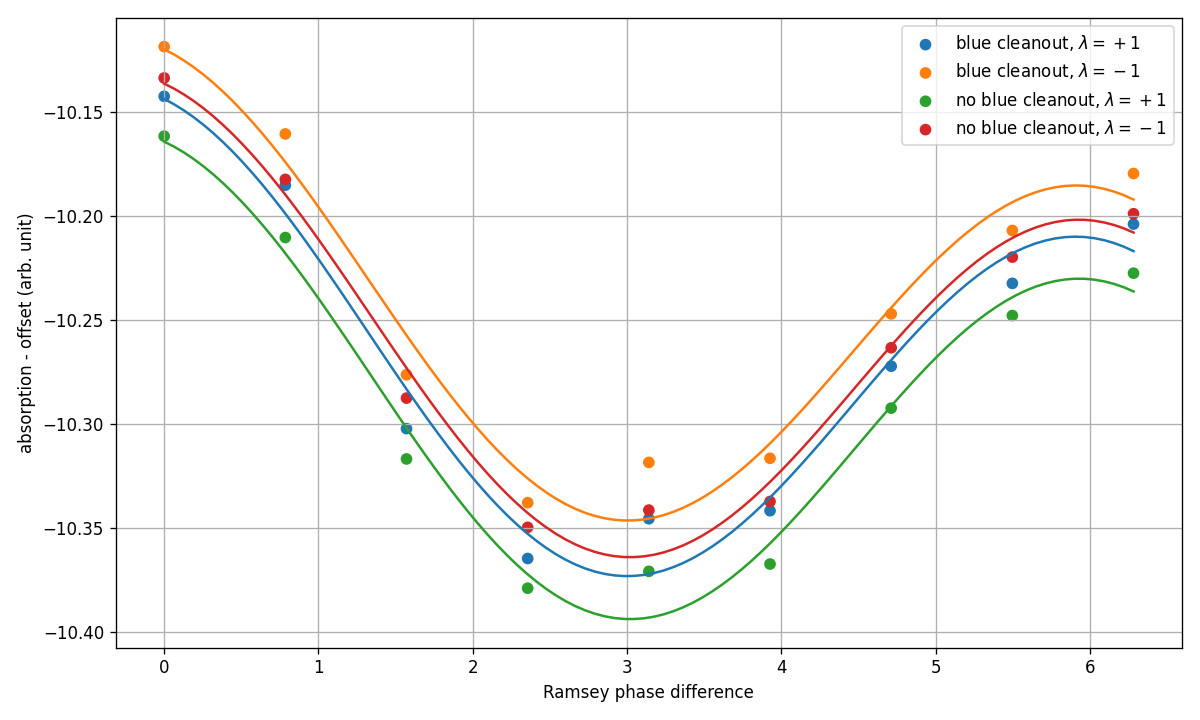

SNR with 9 phase points = 14.577450496353903


In [2155]:
do_average = True

data = {
    # "basis": (989631, 989638),
    # "1.0": (1037430, 1037555),
    # "1.5": (1037805, 1037912),
    # "2.0": (1038203, 1038292),
    # "2.1": (1039716, 1039778),
    # "2.2": (1039910, 1039999),
    # "2.3": (1040081, 1040125),
    # "2.4": (1040890, 1041069),
    # "2.5": (1038500, 1038544),
    # "3.0": (1038806, 1039003),
    # "3.5": (1039207, 1039350),
    # "4.0": (1039507, 1039533),
    # "12.8 ms x 2 probe, 100 ms ac, 50 ms cb": (1042865, 1042873),
    # "0 - 4pi, randomized 1": (1549431, 1550280),
    #"0 - 4pi, randomized 2": (1552306 + 17 * 50, 1552322 + 17 * 99),
    # "1": (1557037, 1557043),
    # "2": (1557037 -49, 1557043 -49),
    # "0": (1558629, 1558637),
    #"44 h random index": (1062607 + 9 * 1348, 1062607 + 9 * 1349 - 1),
    "blue cleanout": (1570587, 1570766),
    "no blue cleanout": (1570413, 1570529),
    # "blue cleanout, no cb": (1568553, 1568561),
    # "no blue cleanout, no cb": (1568671, 1568679),
}

index = []
fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    headers, results = get_results(data_range)
    mask = np.ones(len(headers), dtype=bool)
    for kk, header in enumerate(headers):
        sequence = header["params"]["sequence"]["sequence"]
        if header["params"]["field_plate"]["amplitude"] < 0:
            mask[kk] = True
        for name, repeat in sequence:
            if name.startswith("lf"):
                index.append(int(name.split("_")[-1]))
                break
    xs = np.array([header["params"]["lf"]["phase_diffs"][index[kk]] for kk, header in enumerate(headers)])
    print(xs[:17] / np.pi * 4)
    if results.ndim == 1:
        ys = unumpy.nominal_values(results)
        errs = unumpy.std_devs(results)
        ax.errorbar(xs, ys, errs, label=label, marker='o', linestyle='')
    else:
        for kk in range(0, 2):
            ys = unumpy.nominal_values(results[:, kk])
            errs = unumpy.std_devs(results[:, kk])
            if do_average:
                xs_avg, ys_avg, errs_avg = averaging_ys(xs[mask], ys[mask])
            else:
                xs_avg, ys_avg, errs_avg = xs, ys, errs
            if kk == 0:
                lambda_label = ", $\\lambda = +1$"
            else:
                lambda_label = ", $\\lambda = -1$"
            ax.scatter(xs_avg, ys_avg, label=label + lambda_label, marker='o', linestyle='')
            fitter = get_phase_fitter(xs_avg, ys_avg, None)
            xs_fit = np.linspace(np.min(xs_avg), np.max(xs_avg), 100)
            ys_fit = fitter.fitted_value(xs_fit)
            ax.plot(xs_fit, ys_fit)
            print(label)
            print(fitter.result_str("A"))
            print(fitter.result_str("B"))
            print(fitter.result_str("C"))
            print(fitter.result_str("phi_0"))

ax.set_xlabel("Ramsey phase difference")
ax.set_ylabel("absorption - offset (arb. unit)")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()
print(f"SNR with 9 phase points = {fitter.results["A"]/fitter.errors["A"]}")

IndexError: index 14 is out of bounds for axis 0 with size 9

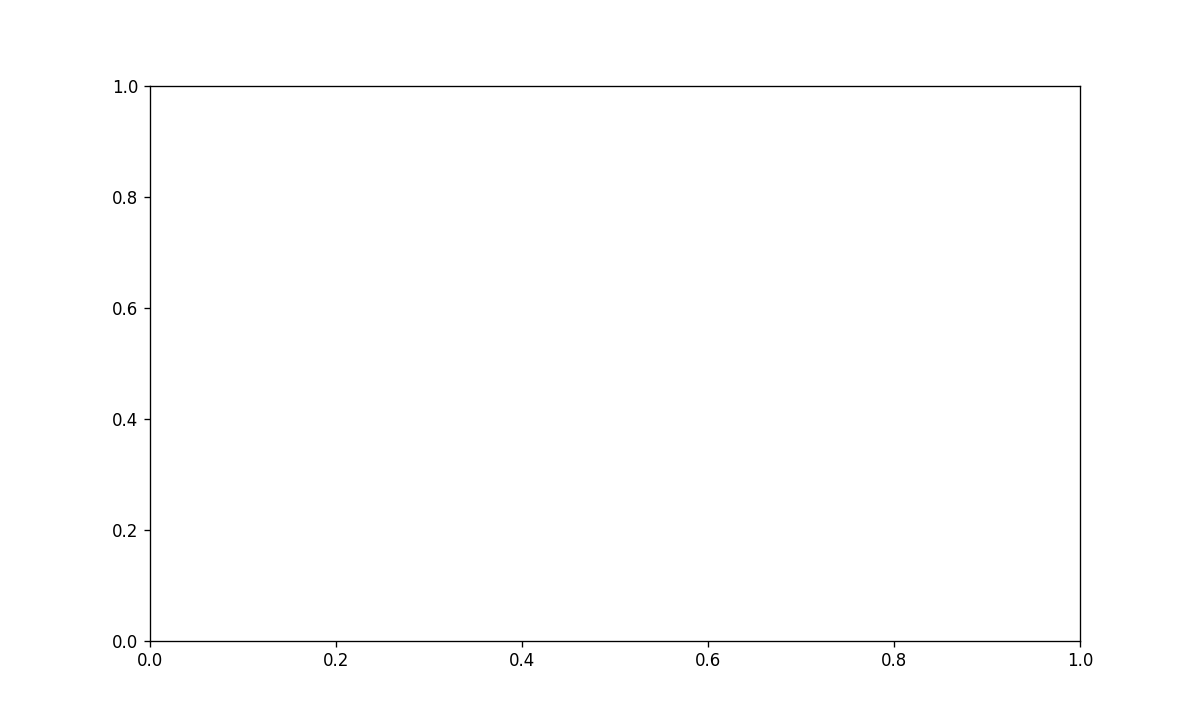

In [2156]:
fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
ax.scatter(
    #xs_avg[np.array([11,  7, 12,  4,  3, 13,  5,  6, 10,  9,  0, 15, 14, 16,  8,  2,  1])],
    np.arange(17),
    fitter.residuals()[np.array([8, 14, 1, 7, 13, 11, 15, 5, 6, 9, 0, 16, 12, 2, 3, 10, 4])]
)
#ax.set_xlabel("Ramsey phase difference")
ax.set_xlabel("Probe order")
ax.set_ylabel("fit residual")
plt.show()

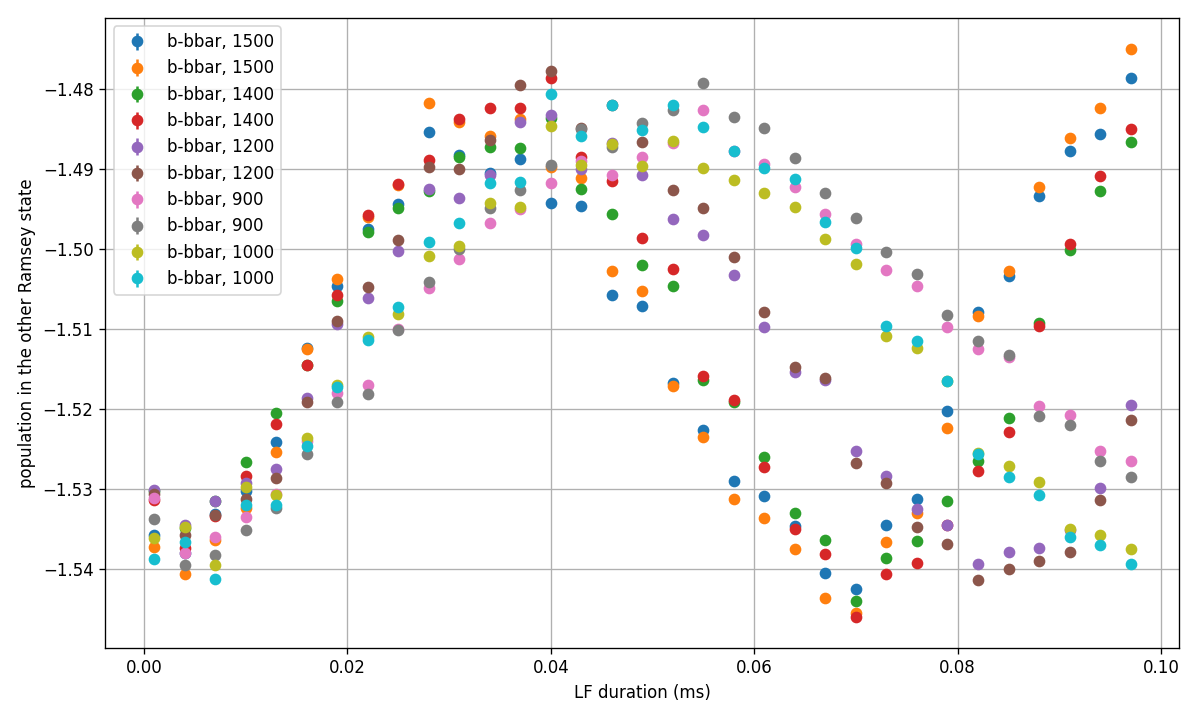

In [1839]:
data = {
    "b-bbar, 1500": (985296, 985328),
    "b-bbar, 1400": (985329, 985361),
    "b-bbar, 1200": (985362, 985394),
    "b-bbar, 900": (985395, 985427),
    "b-bbar, 1000": (985428, 985460),
}

fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    headers, results = get_results(data_range)
    xs = [(header["params"]["lf"]["durations"][0]).to("ms").magnitude for header in headers]
    if results.ndim == 1:
        ys = unumpy.nominal_values(results)
        errs = unumpy.std_devs(results)
        ax.errorbar(xs, ys, errs, label=label, marker='o', linestyle='')
    else:
        for kk in range(2):
            ys = unumpy.nominal_values(results[:, kk])
            errs = unumpy.std_devs(results[:, kk])
            ax.errorbar(xs, ys, errs, label=label, marker='o', linestyle='')

ax.set_xlabel(f"LF duration (ms)")
ax.set_ylabel("population in the other Ramsey state")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

## long term 2-point

In [427]:
def get_lt_experiment_result(data_identification):
    data_list = data_identification_to_list(data_identification)
    slope = 1e-4
    min_detuning = (251.3 - 1.5) * 1e3
    detuning_diff = 3e3
    field_plates = []
    times = []
    f_p = []
    f_m = []
    y0_diffs = []
    for data_number in data_list:
        detunings, data, header = get_normalized_transmission(data_number)
        for kk, field_plate in enumerate([False, True, True, False]):
            for ll, lf_order in enumerate([False, True]):
                y0 = 0
                y1 = 0
                if lf_order:
                    lf_indices = [0, 1]
                else:
                    lf_indices = [1, 0]
                for mm, lf_index in enumerate(lf_indices):
                    detect_index_group = kk * 4 + ll * 2 + mm
                    total_pop_1 = data[str(detect_index_group * 6 + 1)] - data[str(detect_index_group * 6 + 2)]
                    pop_other_state_1 = data[str(detect_index_group * 6 + 1)] - data[str(detect_index_group * 6 + 3)]
                    total_pop_2 = data[str(detect_index_group * 6 + 4)] - data[str(detect_index_group * 6 + 5)]
                    pop_other_state_2 = data[str(detect_index_group * 6 + 5)] - data[str(detect_index_group * 6 + 6)]
                    results = (pop_other_state_1 + pop_other_state_2) / (total_pop_1 + total_pop_2)
                    if lf_index == 0:
                        y0 = results
                    else:
                        y1 = results
                y0_diffs.append(y1[1] - y1[0])
                #print(lf_order, y1 - y0)
                delta_y_sum = detuning_diff * slope
                delta_y_red = (delta_y_sum - (y0 - y1)) / 2
                freq_center = detuning_diff / delta_y_sum * delta_y_red + min_detuning
                field_plates.append(field_plate)
                if field_plate:
                    f_p.append(freq_center[1::2])
                    f_m.append(freq_center[0::2])
                else:
                    f_p.append(freq_center[0::2])
                    f_m.append(freq_center[1::2])
                if "start_time" in header:
                    duration = (header["data_info"]["save_epoch_time"] - header["start_time"]) / 8
                else:
                    duration = 0.1
                times.append(header["data_info"]["save_epoch_time"] + (kk * 2 + ll) * duration)
    print(np.std(unumpy.nominal_values(y0_diffs)))
    return np.array(times), np.array(field_plates), np.array(f_p), np.array(f_m)

In [282]:
# (978245, 978245 + 372) heating problem

In [283]:
times, field_plates, f_p, f_m = get_lt_experiment_result((978638, 978638 + 200)) # 5740, overnight
# times, field_plates, f_p, f_m = get_lt_experiment_result((984410, 984410 + 30))
# times, field_plates, f_p, f_m = get_lt_experiment_result((984448, 984448 + 10)) # 0.0, 2
# times, field_plates, f_p, f_m = get_lt_experiment_result((984461, 984461 + 6)) # 0.5, 2
# times, field_plates, f_p, f_m = get_lt_experiment_result((984468, 984468 + 20)) # -0.5, 2
# times, field_plates, f_p, f_m = get_lt_experiment_result((984489, 984489 + 20)) # -1, 2
# times, field_plates, f_p, f_m = get_lt_experiment_result((984513, 984513 + 6)) # 1, 2

# times, field_plates, f_p, f_m = get_lt_experiment_result((984545, 984545 + 45)) # array, 2
# times, field_plates, f_p, f_m = get_lt_experiment_result((984593, 984593 + 70)) # array, 2.1

0.004474973520445893


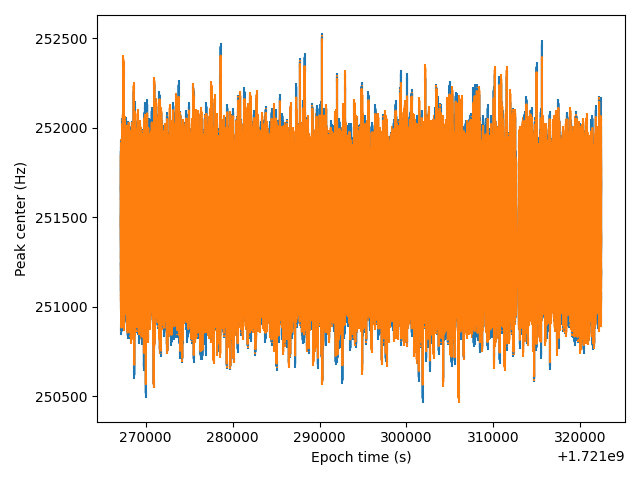

In [272]:
fig, ax = plt.subplots()
for kk in range(len(f_p[0])):
    ax.errorbar(times, unumpy.nominal_values(f_p)[:, kk], unumpy.std_devs(f_p)[:, kk])
    ax.errorbar(times, unumpy.nominal_values(f_m)[:, kk], unumpy.std_devs(f_m)[:, kk])
ax.set_ylabel("Peak center (Hz)")
ax.set_xlabel("Epoch time (s)")
plt.tight_layout()
plt.show()

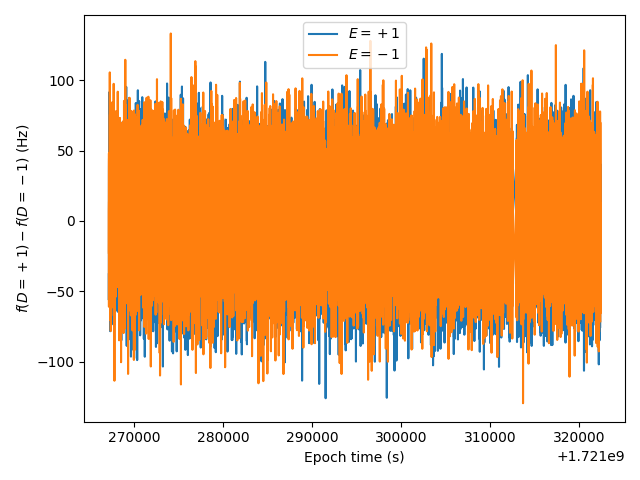

In [273]:
fig, ax = plt.subplots()
ax.plot(times[field_plates], (unumpy.nominal_values(f_p) - unumpy.nominal_values(f_m))[field_plates], label="$E=+1$")
ax.plot(times[~field_plates], (unumpy.nominal_values(f_p) - unumpy.nominal_values(f_m))[~field_plates], label="$E=-1$")
ax.set_ylabel("$f(D=+1) - f(D=-1)$ (Hz)")
ax.set_xlabel("Epoch time (s)")
ax.legend()
plt.tight_layout()
plt.show()

In [275]:
for kk in range(len(f_p[0])):
    print(kk)
    W_T = ufloat(
        np.average(unumpy.nominal_values(f_p[:, kk]) - unumpy.nominal_values(f_m[:, kk])),
        np.std(unumpy.nominal_values(f_p[:, kk]) - unumpy.nominal_values(f_m[:, kk])) / np.sqrt(len(f_p[:, kk]))
    )
    print(W_T, "Hz")
    print(round(np.std(unumpy.nominal_values(f_p[:, kk]) - unumpy.nominal_values(f_m[:, kk])), 2))
    print()

0
0.23+/-0.15 Hz
31.72



In [270]:
for kk in range(len(f_p[0])):
    print(kk)
    W_T_E_p1 = ufloat(
        np.average((unumpy.nominal_values(f_p[:, kk]) - unumpy.nominal_values(f_m[:, kk]))[field_plates]),
        np.std((unumpy.nominal_values(f_p[:, kk]) - unumpy.nominal_values(f_m[:, kk]))[field_plates]) / np.sqrt(len(f_p[:, kk][field_plates]))
    )
    print(W_T_E_p1)
    print(round(np.std((unumpy.nominal_values(f_p[:, kk]) - unumpy.nominal_values(f_m[:, kk]))[field_plates]), 2))
    print()

0
-2.13+/-0.21
31.59



In [271]:
for kk in range(len(f_p[0])):
    print(kk)
    W_T_E_m1 = ufloat(
        np.average((unumpy.nominal_values(f_p[:, kk]) - unumpy.nominal_values(f_m[:, kk]))[~field_plates]),
        np.std((unumpy.nominal_values(f_p[:, kk]) - unumpy.nominal_values(f_m[:, kk]))[~field_plates]) / np.sqrt(len(f_p[:, kk][~field_plates]))
    )
    print(W_T_E_m1)
    print(round(np.std((unumpy.nominal_values(f_p[:, kk]) - unumpy.nominal_values(f_m[:, kk]))[~field_plates]), 2))
    print()

0
2.60+/-0.21
31.67



## long term phase scan

In [408]:
import onix.models.hyperfine as hyperfine
magnetic_field = 223e-4
ground = hyperfine.states["7F0"]
ground._Hamiltonian = ground.H_total(magnetic_field)
e_g, s_g = ground.energies_and_eigenstates()

a_I_dot_n = (s_g[0].dag() * ground._I_x * s_g[0]).tr()
abar_I_dot_n = (s_g[1].dag() * ground._I_x * s_g[1]).tr()
b_I_dot_n = (s_g[2].dag() * ground._I_x * s_g[2]).tr()
bbar_I_dot_n = (s_g[3].dag() * ground._I_x * s_g[3]).tr()
I_a = (abar_I_dot_n - a_I_dot_n) / 2
I_b = (bbar_I_dot_n - b_I_dot_n) / 2

def combine_polarization_data(results):
    def check_equal_and_append(check_from, check_name, append_to):
        check_col = check_from[:, col_indices[check_name]]
        count = np.unique(check_col)
        if len(count) > 1:
            raise Exception(f"{check_name} is not the same.")
        append_to.append(check_col[0])

    results_array = pandas.DataFrame.from_dict(results).to_numpy()
    keys = list(results.keys())
    indices = list(range(len(keys)))
    col_indices = dict(zip(keys, indices))
    data = {
        "f+": [],
        "f-": [],
        "start_time": [],
        "end_time": [],
    }
    for kk in range(len(results_array) // 2):
        sub_data = results_array[kk * 2: kk * 2 + 2]
        data_indices = []
        for name in results.keys():
            if name not in ["start_time", "end_time", "D", "freq_center"]:
                if name not in data:
                    data[name] = []
                check_equal_and_append(sub_data, name, data[name])
        for ll, datapoint in enumerate(sub_data):
            if ll == 0:
                start_time = datapoint[col_indices["start_time"]]
            if ll == len(sub_data) - 1:
                end_time = datapoint[col_indices["end_time"]]
            if datapoint[col_indices["D"]]:
                f_p = datapoint[col_indices["freq_center"]]
            else:
                f_m = datapoint[col_indices["freq_center"]]

        data["f+"].append(f_p)
        data["f-"].append(f_m)
        data["start_time"].append(start_time)
        data["end_time"].append(end_time)

    data["f+"] = np.array(data["f+"])
    data["f-"] = np.array(data["f-"])
    data["Z"] = (data["f+"] + data["f-"]) / 4
    data["W_T"] = []
    for kk in range(len(data["f+"])):
        if data["state"][kk] == "a":
            I = I_a
        else:
            I = I_b
        data["W_T"].append((data["f+"][kk] - data["f-"][kk]) / 4 / I)

    keys = list(data.keys())
    indices = list(range(len(keys)))
    col_indices = dict(zip(keys, indices))
    data = pandas.DataFrame.from_dict(data).to_numpy()
    return data, col_indices

In [ ]:
data, 

In [2108]:
# data_range = (1555028 + 0 * 49, 1555034 + 0 * 49)  #--- data: scanning carrier frequencies and phases 
# max = 1557043

data_range = (1557099+90, 1557107+90) # scanning 140.946, 141.046, 141.146, 141.246, 141.346
max = 1565792

first = data_range[0]
last = max

current = data_range[-1]
offset = 0
all_results = {
    "lf_center_freq": [],
    "freq_center": [],
    "state": [],
    "E": [],
    "D": [],
    "field_plate_amplitude": [],
    "electric_field_shift_MHz": [],
    "pulse_time_ms": [],
    "wait_time_ms": [],
    "start_time": [],
    "end_time": [],
}
heights = []
diff_heights = []

while current + offset <= max:
    data_range_now = (data_range[0] + offset, data_range[1] + offset)
    data_list = data_identification_to_list(data_range_now)
    headers, results = get_results(data_range_now)
    
    index = []
    for header in headers:
        sequence = header["params"]["sequence"]["sequence"]
        for name, repeat in sequence:
            if name.startswith("lf"):
                index.append(int(name.split("_")[-1]))
                break
                
    center_freq = headers[0]["params"]["lf"]["center_frequencies"][index[0]].to("Hz").magnitude
    pulse_time_ms = headers[0]["params"]["lf"]["durations"][0].to("ms").magnitude
    wait_time_ms = headers[0]["params"]["lf"]["wait_times"][0].to("ms").magnitude
    total_time_ms = pulse_time_ms + wait_time_ms
    detuning = headers[0]["params"]["lf"]["detunings"][0].to("Hz").magnitude
    probe_freq = center_freq + detuning
    fp_amplitude = headers[0]["params"]["field_plate"]["amplitude"]
    stark_shift = headers[0]["params"]["field_plate"]["stark_shift"].to("MHz").magnitude
    E_field = fp_amplitude > 0
    phases = [header["params"]["lf"]["phase_diffs"][index[kk]] for kk, header in enumerate(headers)]

    for kk in range(2):  # positive and negative Stark components.
        ys = unumpy.nominal_values(results[:, kk])
        errs = unumpy.std_devs(results[:, kk])
        fitter = get_phase_fitter(phases, ys, None)
        phi0 = ufloat(fitter.results["phi_0"], fitter.errors["phi_0"])
        freq_center = phi0 / (2 * np.pi) / (total_time_ms * 1e-3) + probe_freq
        
        neg_DdotE = kk == 0
        E = E_field
        D = (not neg_DdotE) == E
        epoch_times = (
            headers[0]["data_info"]["save_epoch_time"],
            headers[-1]["data_info"]["save_epoch_time"],
        )
        if probe_freq > 200e3:
            state = "a"
        else:
            state = "b"
        all_results["lf_center_freq"].append(center_freq)
        all_results["freq_center"].append(freq_center)
        all_results["state"].append(state)
        all_results["E"].append(E)
        all_results["D"].append(D)
        all_results["start_time"].append(epoch_times[0])
        all_results["end_time"].append(epoch_times[1])
        all_results["pulse_time_ms"].append(pulse_time_ms)
        all_results["wait_time_ms"].append(wait_time_ms)
        all_results["field_plate_amplitude"].append(fp_amplitude)
        all_results["electric_field_shift_MHz"].append(stark_shift)

        heights.append(ys)
    if E_field:
        diff_heights.append(heights[-1] - heights[-2])
    else:
        diff_heights.append(heights[-2] - heights[-1])
    offset += len(list(data_list))

results, col_indices = combine_polarization_data(all_results)
print(np.average(np.std(heights, axis=0)))
print(np.average(np.std(diff_heights, axis=0)))

0.20373716641872516
0.04117592088126207


In [2109]:
all_results["start_time"][2] - all_results["start_time"][0]

4.037332057952881

In [2110]:
a_mask = results[:, col_indices["state"]] == "a"
b_mask = results[:, col_indices["state"]] == "b"

E_fields = np.unique(results[:, col_indices["field_plate_amplitude"]])
E_masks = [results[:, col_indices["field_plate_amplitude"]] == kk for kk in E_fields]

E_pos_mask = results[:, col_indices["E"]] == True
E_neg_mask = results[:, col_indices["E"]] == False

start_times_a = results[a_mask, col_indices["start_time"]]
start_times_b = results[b_mask, col_indices["start_time"]]
f_p_a = results[a_mask, col_indices["f+"]]
f_m_a = results[a_mask, col_indices["f-"]]
f_p_b = results[b_mask, col_indices["f+"]]
f_m_b = results[b_mask, col_indices["f-"]]

Z_a = results[a_mask, col_indices["Z"]]
Z_b = results[b_mask, col_indices["Z"]]
W_T_a = results[a_mask, col_indices["W_T"]]
W_T_b = results[b_mask, col_indices["W_T"]]

lf_center_freq_masks = []
for lf_center_freq in np.unique(results[:, col_indices["lf_center_freq"]]):
    lf_center_freq_masks.append(results[:, col_indices["lf_center_freq"]] == lf_center_freq)

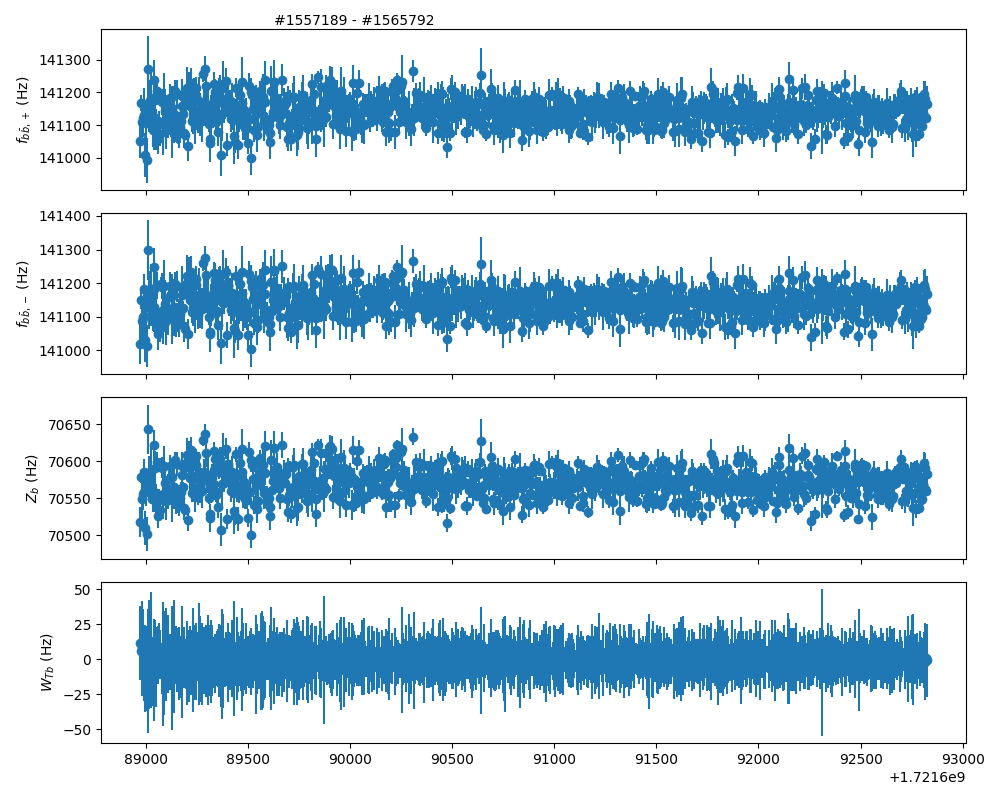

f_b,+ = 141141.1(1.3) Hz
f_b,- = 141142.3(1.4) Hz
Δf(b; D=±1 ,E=+1) = -0.36(8) Hz
Δf(b; D=±1 ,E=-1) = -0.45(8) Hz


In [2111]:
errorbar_args = {"fmt": "o", "ls": "none"}

masks = {}
if not np.all(a_mask == False):
    masks["a"] = a_mask
if not np.all(b_mask == False):
    masks["b"] = b_mask

cols = len(masks) * 4
fig, axs = plt.subplots(cols, 1, sharex=True, figsize=(10, cols*2))
for ll, mask_name in enumerate(masks):
    mask = masks[mask_name]
    E_pos = E_pos_mask[mask]
    E_neg = E_neg_mask[mask]
    
    axs[ll].set_ylabel("$f_{" + mask_name + "\\bar{" + mask_name + "}, +}$ (Hz)")
    axs[len(masks) + ll].set_ylabel("$f_{" + mask_name + "\\bar{" + mask_name + "}, -}$ (Hz)")
    axs[len(masks) * 2 + ll].set_ylabel("$Z_" + mask_name + "$ (Hz)")
    axs[len(masks) * 3 + ll].set_ylabel("$W_{T" + mask_name + "}$ (Hz)")
    for kk, d in enumerate(
        [
            results[mask, col_indices["f+"]],
            results[mask, col_indices["f-"]],
            results[mask, col_indices["Z"]],
            results[mask, col_indices["W_T"]]
        ]
    ):
        axs[kk * len(masks) + ll].errorbar(
            results[mask, col_indices["start_time"]], unumpy.nominal_values(d), unumpy.std_devs(d),
            **errorbar_args
        )
axs[0].text(0.2, 1.02, f'#{first} - #{last}', transform = axs[0].transAxes)
plt.tight_layout()
plt.show()
if "a" in masks:
    mask = masks["a"]
    E_pos = E_pos_mask[mask]
    E_neg = E_neg_mask[mask]
    print("f_a,+ =", present_float(np.average(unumpy.nominal_values(f_p_a)), np.average(np.std(unumpy.nominal_values(f_p_a))) / np.sqrt(len(f_p_a))), "Hz")
    print("f_a,- =", present_float(np.average(unumpy.nominal_values(f_m_a)), np.average(np.std(unumpy.nominal_values(f_m_a))) / np.sqrt(len(f_m_a))), "Hz")
    print("W_Ta, E>0 =", present_float(np.average(unumpy.nominal_values(W_T_a[E_pos])), np.average(np.std(unumpy.nominal_values(W_T_a[E_pos]))) / np.sqrt(len(W_T_a[E_pos]))), "Hz")
    print("W_Ta, E<0 =", present_float(np.average(unumpy.nominal_values(W_T_a[E_neg])), np.average(np.std(unumpy.nominal_values(W_T_a[E_neg]))) / np.sqrt(len(W_T_a[E_neg]))), "Hz")
if "b" in masks:
    mask = masks["b"]
    E_pos = E_pos_mask[mask]
    E_neg = E_neg_mask[mask]
    print("f_b,+ =", present_float(np.average(unumpy.nominal_values(f_p_b)), np.average(np.std(unumpy.nominal_values(f_p_b))) / np.sqrt(len(f_p_b))), "Hz")
    print("f_b,- =", present_float(np.average(unumpy.nominal_values(f_m_b)), np.average(np.std(unumpy.nominal_values(f_m_b))) / np.sqrt(len(f_m_b))), "Hz")
    print("Δf(b; D=±1 ,E=+1) =", present_float(np.average(unumpy.nominal_values(W_T_b[E_pos])), np.average(np.std(unumpy.nominal_values(W_T_b[E_pos]))) / np.sqrt(len(W_T_b[E_pos]))), "Hz")
    print("Δf(b; D=±1 ,E=-1) =", present_float(np.average(unumpy.nominal_values(W_T_b[E_neg])), np.average(np.std(unumpy.nominal_values(W_T_b[E_neg]))) / np.sqrt(len(W_T_b[E_neg]))), "Hz")

N_total = 8604
N_meas = 95.6
Expected delta_f = 3.9565427573101064 Hz


<>:35: SyntaxWarning: invalid escape sequence '\p'
<>:35: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_11166/742389335.py:35: SyntaxWarning: invalid escape sequence '\p'
  axs[1].set_ylabel("atomic phase offset, $\phi_0$ (rad)")


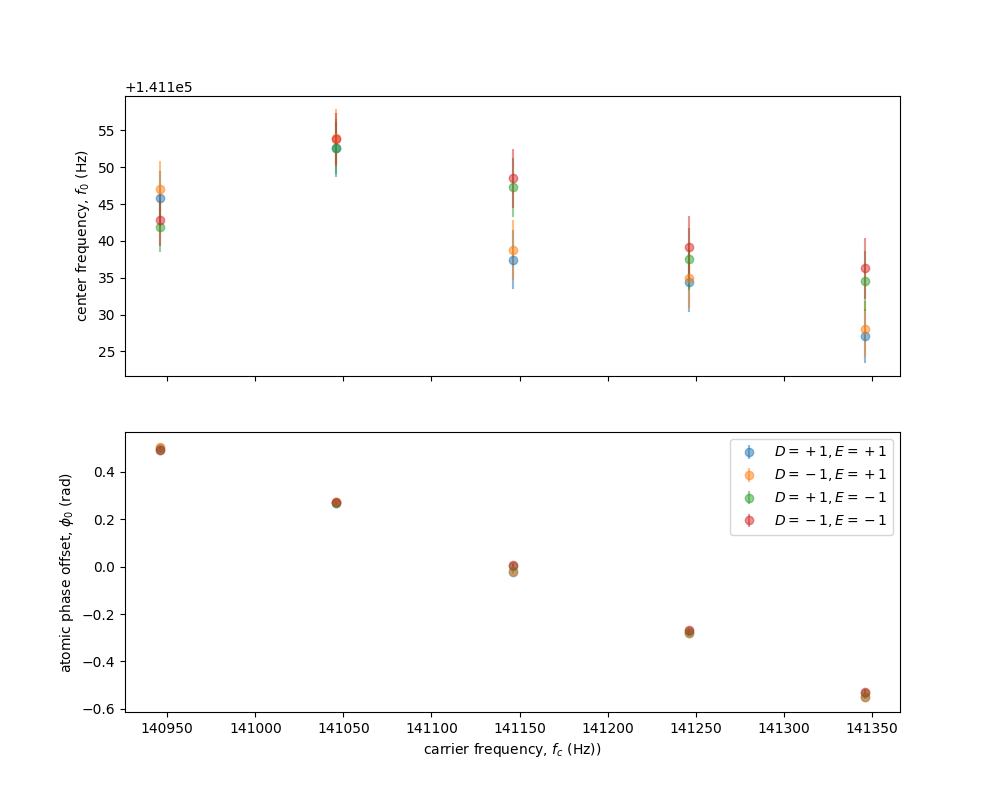

In [2115]:
x = np.unique(results[:, col_indices["lf_center_freq"]])
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
for jj, plotting in enumerate(["freqs", "phases"]):
    ds = []
    ers = []
    for EE in [E_pos_mask, E_neg_mask]:
        for ff in ["f+", "f-"]:
            d = []
            er = []
            for kk in range(len(x)):
                frequencies = results[b_mask&lf_center_freq_masks[kk]&EE, col_indices[ff]]
                phases = 2*np.pi*(frequencies-x[kk])*400e-6
                phases = (phases + np.pi) % (2 * np.pi) - np.pi

                if plotting == "freqs":
                    what_to_plot = frequencies
                elif plotting == "phases":
                    what_to_plot = phases
                
                nom = unumpy.nominal_values(what_to_plot)
                unc = unumpy.std_devs(what_to_plot)
                
                d.append(np.average(nom))
                er.append(np.average(unc)/np.sqrt(len(unc)))
                
            ds.append(d)
            ers.append(er)
    
    axs[jj].errorbar(x, ds[0], ers[0], label="$D = +1, E = +1$", fmt="o", ls="", alpha=0.5)
    axs[jj].errorbar(x, ds[1], ers[1], label="$D = -1, E = +1$", fmt="o", ls="", alpha=0.5)
    axs[jj].errorbar(x, ds[2], ers[2], label="$D = +1, E = -1$", fmt="o", ls="", alpha=0.5)
    axs[jj].errorbar(x, ds[3], ers[3], label="$D = -1, E = -1$", fmt="o", ls="", alpha=0.5)

axs[0].set_ylabel("center frequency, $f_0$ (Hz)")
axs[1].set_ylabel("atomic phase offset, $\phi_0$ (rad)")
axs[1].set_xlabel("carrier frequency, $f_c$ (Hz))")
plt.legend()
print(f"N_total = {(max-data_range[0]+1)}")
print(f"N_meas = {(max-data_range[0]+1)/(5*2*9)}")
print(f"Expected delta_f = {367/np.sqrt(max-data_range[0]+1)} Hz")
plt.show()

In [2113]:
W_tb_unc = np.average(np.std(unumpy.nominal_values(W_T_b))) / np.sqrt(len(W_T_b))
duration = np.max(results[mask, col_indices["start_time"]]) - np.min(results[mask, col_indices["start_time"]])
print("W_Tb =", present_float(np.average(unumpy.nominal_values(W_T_b)), W_tb_unc, 2), "Hz")

W_Tb = -0.402(57) Hz


In [2091]:
print(f'#{first} - #{last}')
print(duration)
print(f"{W_tb_unc / np.sqrt(3600 / duration):.3f} Hz sqrt(hr)")

#1555028 - #1557043
894.7038888931274
3.202 Hz sqrt(hr)


In [2092]:
print(f'#{first} - #{last}')
mask = masks["b"]
E_pos = E_pos_mask[mask]
E_neg = E_neg_mask[mask]
print("f_b,+ =", present_float(np.average(unumpy.nominal_values(f_p_b)), np.average(np.std(unumpy.nominal_values(f_p_b))) / np.sqrt(len(f_p_b))), "Hz")
print("f_b,- =", present_float(np.average(unumpy.nominal_values(f_m_b)), np.average(np.std(unumpy.nominal_values(f_m_b))) / np.sqrt(len(f_m_b))), "Hz")
W_tb_unc = np.average(np.std(unumpy.nominal_values(W_T_b))) / np.sqrt(len(W_T_b))
duration = np.max(results[mask, col_indices["start_time"]]) - np.min(results[mask, col_indices["start_time"]])
print("W_T =", present_float(np.average(unumpy.nominal_values(W_T_b)), W_tb_unc, 2), "Hz")
print("Δf(b; D=±1 ,E=+1) =", present_float(np.average(unumpy.nominal_values(W_T_b[E_pos])), np.average(np.std(unumpy.nominal_values(W_T_b[E_pos]))) / np.sqrt(len(W_T_b[E_pos]))), "Hz")
print("Δf(b; D=±1 ,E=-1) =", present_float(np.average(unumpy.nominal_values(W_T_b[E_neg])), np.average(np.std(unumpy.nominal_values(W_T_b[E_neg]))) / np.sqrt(len(W_T_b[E_neg]))), "Hz")

#1555028 - #1557043
f_b,+ = 141470(60) Hz
f_b,- = 141450(60) Hz
W_T = 8.2(6.4) Hz
Δf(b; D=±1 ,E=+1) = 5(10) Hz
Δf(b; D=±1 ,E=-1) = 11(8) Hz


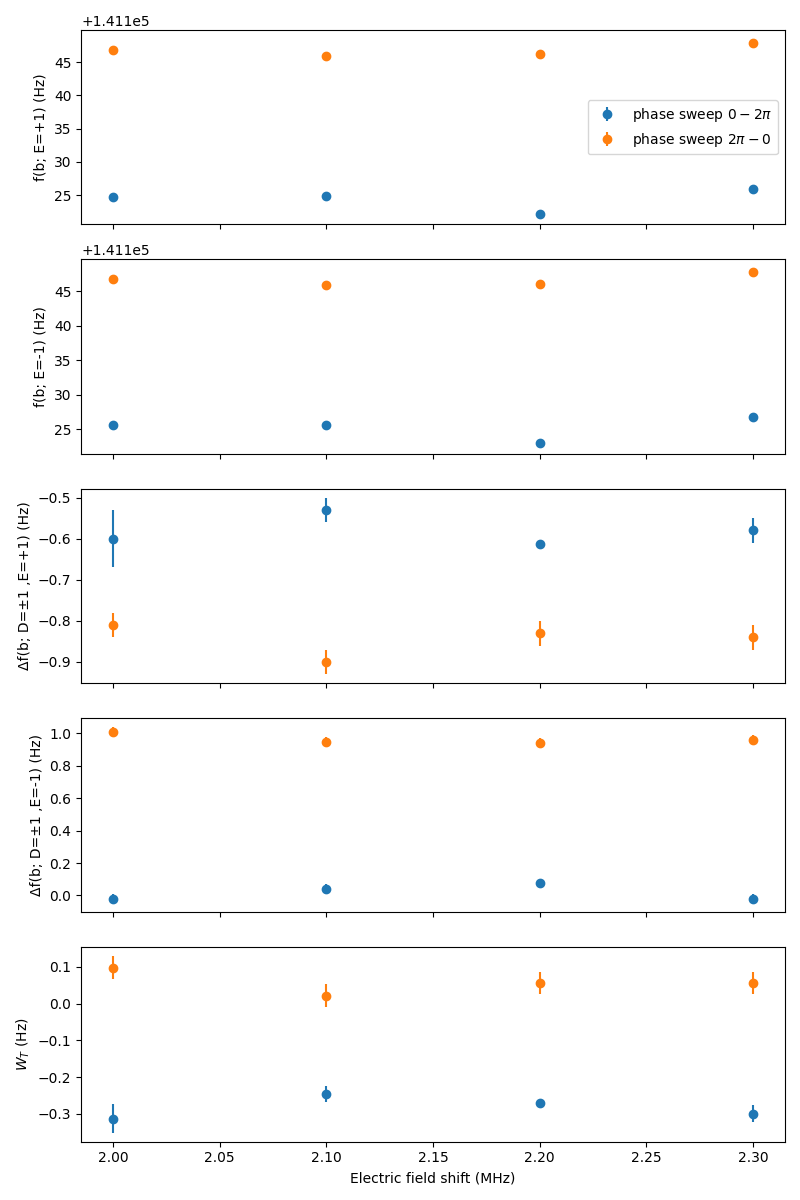

In [1772]:
e_shifts_1 = np.array(
    [2.2, 2.3, 2.0, 2.1],
)
fbps_1 = unumpy.uarray(
    [141122.2, 141125.9, 141124.7, 141124.8],
    [0.3, 0.5, 0.5, 0.4],
)
fbms_1 = unumpy.uarray(
    [141123.0, 141126.8, 141125.6, 141125.6],
    [0.3, 0.5, 0.5, 0.5],
)
W_Ts_1 = unumpy.uarray(
    [-0.2697, -0.300, -0.313, -0.247],
    [0.0047, 0.023, 0.039, 0.022],
)
fbEps_1 = unumpy.uarray(
    [-0.613, -0.58, -0.60, -0.53],
    [0.006, 0.03, 0.07, 0.03],
)
fbEms_1 = unumpy.uarray(
    [0.074, -0.02, -0.02, 0.04],
    [0.006, 0.03, 0.03, 0.03],
)

e_shifts_2 = np.array(
    [2.2, 2.1, 2.0, 2.3],
)
fbps_2 = unumpy.uarray(
    [141146.2, 141146.0, 141146.9, 141147.9],
    [0.5, 0.5, 0.5, 0.6],
)
fbms_2 = unumpy.uarray(
    [141146.0, 141145.9, 141146.7, 141147.7],
    [0.5, 0.5, 0.5, 0.6],
)
W_Ts_2 = unumpy.uarray(
    [0.055, 0.022, 0.098, 0.056],
    [0.030, 0.032, 0.031, 0.031],
)
fbEps_2 = unumpy.uarray(
    [-0.83, -0.90, -0.81, -0.84],
    [0.03, 0.03, 0.03, 0.03],
)
fbEms_2 = unumpy.uarray(
    [0.94, 0.95, 1.01, 0.96],
    [0.03, 0.03, 0.03, 0.03],
)

fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8, 12))
for kk, (label, variable_name) in enumerate(
    [
        ("f(b; E=+1) (Hz)", "fbps"),
        ("f(b; E=-1) (Hz)", "fbms"),
        ("Δf(b; D=±1 ,E=+1) (Hz)", "fbEps"),
        ("Δf(b; D=±1 ,E=-1) (Hz)", "fbEms"),
        ("$W_T$ (Hz)", "W_Ts"),
    ]
):
    ax[kk].errorbar(e_shifts_1, unumpy.nominal_values(eval(variable_name + "_1")), unumpy.std_devs(eval(variable_name + "_1")), fmt="o", ls="none", label="phase sweep $0 - 2\\pi$")
    ax[kk].errorbar(e_shifts_2, unumpy.nominal_values(eval(variable_name + "_2")), unumpy.std_devs(eval(variable_name + "_2")), fmt="o", ls="none", label="phase sweep $2\\pi - 0$")
    ax[kk].set_ylabel(label)
ax[0].legend()
ax[-1].set_xlabel("Electric field shift (MHz)")
plt.tight_layout()
plt.show()